In [1]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
%matplotlib inline
import seaborn as sns; sns.set_theme(color_codes=True)
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
import math

In [2]:
labels = gpd.read_file('data/seattle_labels.geojson')
curb = labels.loc[(labels['label_type']=='CurbRamp')]
#change coordinate system
curb = curb.to_crs("EPSG:2285")
no_curb = labels.loc[(labels['label_type']=='NoCurbRamp')]
no_curb = no_curb.to_crs("EPSG:2285")

In [4]:
#read in shapefile data/seattle-osm-roads.shp
roads = gpd.read_file('data/seattle-osm-roads/seattle-osm-roads.shp')

In [9]:
#roads.explore( column='highway', tiles='cartodbpositron', cmap='Set2')


Text(0.5, 1.0, 'Roads by Highway Type')

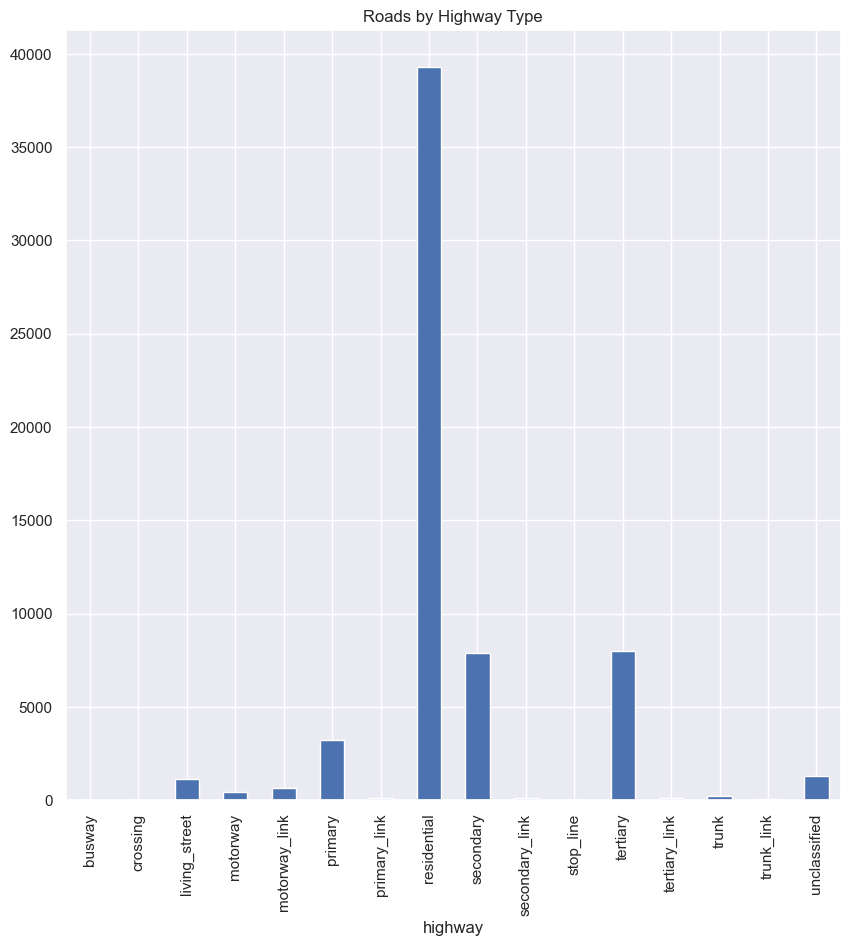

In [11]:
#plot roads by highway type in bar chart 
fig, ax = plt.subplots(figsize=(10,10))
roads.groupby('highway').size().plot(kind='bar', ax=ax)
ax.set_title('Roads by Highway Type')

In [110]:
#change highway column name to way_type
roads.rename(columns={'highway':'way_type'}, inplace=True)

In [111]:
#drop way_type = motorway and motorway_link
roads = roads[roads.way_type != 'motorway']
roads = roads[roads.way_type != 'motorway_link']

In [112]:
roads

,way_type,osmid,geometry
21,secondary,426250827,"LINESTRING (-122.30363 47.64413, -122.30389 47..."
22,primary,4636259,"LINESTRING (-122.30363 47.64413, -122.30369 47..."
23,primary,361443212,"LINESTRING (-122.30363 47.64413, -122.30369 47..."
24,primary,431103955,"LINESTRING (-122.30363 47.64413, -122.30369 47..."
25,secondary,332060260,"LINESTRING (-122.30389 47.64403, -122.30395 47..."
...,...,...,...
62595,residential,340365566,"LINESTRING (-122.34106 47.63658, -122.34134 47..."
62596,residential,1138304083,"LINESTRING (-122.30830 47.49990, -122.30830 47..."
62597,residential,6399535,"LINESTRING (-122.30830 47.49933, -122.30741 47..."
62598,residential,1138304083,"LINESTRING (-122.30830 47.49933, -122.30830 47..."


In [113]:
# Extract start and end coordinates of each linestring
first_coord = roads["geometry"].apply(lambda g: g.coords[0])
last_coord = roads["geometry"].apply(lambda g: g.coords[-1])

# Add start and end as columns to the s
roads["start_coord"] = first_coord
roads["end_coord"] = last_coord

In [114]:
p0 = roads[['start_coord', 'way_type']]
p1 = roads[['end_coord','way_type']]
p0 = p0.rename(columns={'start_coord':'coord'})
p1 = p1.rename(columns={'end_coord':'coord'})
result = pd.concat([p0,p1])
result = result.drop_duplicates(subset=['coord','way_type'], keep='first')
result

,coord,way_type
21,"(-122.3036315, 47.6441329)",secondary
22,"(-122.3036315, 47.6441329)",primary
25,"(-122.303892, 47.6440305)",secondary
34,"(-122.3014251, 47.6583247)",primary
38,"(-122.3021215, 47.6560111)",primary
...,...,...
62365,"(-122.3182273, 47.6017022)",secondary_link
62486,"(-122.31338, 47.5638073)",tertiary
62487,"(-122.3132123, 47.563601)",secondary_link
62493,"(-122.3200798, 47.5473539)",residential


In [115]:
#convert points into gpd
points = result.apply(lambda row: Point(row), axis=1)
#fix coordinate system
p_geo = gpd.GeoDataFrame(result, geometry=points)
p_geo.crs = {'init': 'epsg:4326'}
p_geo = p_geo.to_crs("EPSG:2285")
p_geo

,coord,way_type,geometry
21,"(-122.3036315, 47.6441329)",secondary,POINT (1278000.237 238421.440)
22,"(-122.3036315, 47.6441329)",primary,POINT (1278000.237 238421.440)
25,"(-122.303892, 47.6440305)",secondary,POINT (1277935.320 238385.322)
34,"(-122.3014251, 47.6583247)",primary,POINT (1278642.794 243586.795)
38,"(-122.3021215, 47.6560111)",primary,POINT (1278455.097 242746.302)
...,...,...,...
62365,"(-122.3182273, 47.6017022)",secondary_link,POINT (1274104.275 223016.157)
62486,"(-122.31338, 47.5638073)",tertiary,POINT (1275034.052 209172.938)
62487,"(-122.3132123, 47.563601)",secondary_link,POINT (1275074.000 209096.904)
62493,"(-122.3200798, 47.5473539)",residential,POINT (1273264.306 203204.319)


In [116]:
# add a column based on way_type called buffer_ft
# 1. primary = 120
# 2. secondary = 100
# 3. tertiary = 80
# 4. residential = 40
# everything else = 60
p_geo['buffer_ft_1'] = p_geo['way_type'].apply(lambda x: 120 if x == 'primary' else 100 if x == 'secondary' else 80 if x == 'tertiary' else 60)
p_geo['buffer_ft_2'] = p_geo['way_type'].apply(lambda x: 120 if x == 'primary' else 100 if x == 'secondary' else 80 if x == 'tertiary' else 40 if x == 'residential' else 60)
p_geo

,coord,way_type,geometry,buffer_ft_1,buffer_ft_2
21,"(-122.3036315, 47.6441329)",secondary,POINT (1278000.237 238421.440),100,100
22,"(-122.3036315, 47.6441329)",primary,POINT (1278000.237 238421.440),120,120
25,"(-122.303892, 47.6440305)",secondary,POINT (1277935.320 238385.322),100,100
34,"(-122.3014251, 47.6583247)",primary,POINT (1278642.794 243586.795),120,120
38,"(-122.3021215, 47.6560111)",primary,POINT (1278455.097 242746.302),120,120
...,...,...,...,...,...
62365,"(-122.3182273, 47.6017022)",secondary_link,POINT (1274104.275 223016.157),60,60
62486,"(-122.31338, 47.5638073)",tertiary,POINT (1275034.052 209172.938),80,80
62487,"(-122.3132123, 47.563601)",secondary_link,POINT (1275074.000 209096.904),60,60
62493,"(-122.3200798, 47.5473539)",residential,POINT (1273264.306 203204.319),60,40


In [117]:
p_geo['way_type'].unique()

array(['secondary', 'primary', 'secondary_link', 'residential',
       'tertiary', 'unclassified', 'primary_link', 'trunk_link', 'trunk',
       'living_street', 'tertiary_link', 'busway', 'crossing',
       'stop_line'], dtype=object)

In [118]:
buffered_1 = p_geo.copy()
buffered_1['geometry'] = buffered_1.apply(lambda x: x.geometry.buffer(x.buffer_ft_1), axis=1)
buffered_1.head(3)

,coord,way_type,geometry,buffer_ft_1,buffer_ft_2
21,"(-122.3036315, 47.6441329)",secondary,"POLYGON ((1278100.237 238421.440, 1278099.755 ...",100,100
22,"(-122.3036315, 47.6441329)",primary,"POLYGON ((1278120.237 238421.440, 1278119.659 ...",120,120
25,"(-122.303892, 47.6440305)",secondary,"POLYGON ((1278035.320 238385.322, 1278034.838 ...",100,100


In [119]:
buffered_2 = p_geo.copy()
buffered_2['geometry'] = buffered_2.apply(lambda x: x.geometry.buffer(x.buffer_ft_2), axis=1)
buffered_2.head(3)

,coord,way_type,geometry,buffer_ft_1,buffer_ft_2
21,"(-122.3036315, 47.6441329)",secondary,"POLYGON ((1278100.237 238421.440, 1278099.755 ...",100,100
22,"(-122.3036315, 47.6441329)",primary,"POLYGON ((1278120.237 238421.440, 1278119.659 ...",120,120
25,"(-122.303892, 47.6440305)",secondary,"POLYGON ((1278035.320 238385.322, 1278034.838 ...",100,100


In [120]:
curb_tp_1 = curb.sjoin(buffered_1, op="within", how="inner")
no_curb_tp_1 = no_curb.sjoin(buffered_1, op="within", how="inner")

In [121]:
curb_tp_2 = curb.sjoin(buffered_2, op="within", how="inner")
no_curb_tp_2 = no_curb.sjoin(buffered_2, op="within", how="inner")

In [122]:
id_list_a= curb_tp_1['label_id'].unique().tolist()
curb_fp_1 = curb[~curb['label_id'].isin(id_list_a)]
id_list_b= no_curb_tp_1['label_id'].unique().tolist()
no_curb_fp_1 = no_curb[~no_curb['label_id'].isin(id_list_b)]

In [123]:
id_list_c = curb_tp_2['label_id'].unique().tolist()
curb_fp_2 = curb[~curb['label_id'].isin(id_list_c)]
id_list_d = no_curb_tp_2['label_id'].unique().tolist()
no_curb_fp_2 = no_curb[~no_curb['label_id'].isin(id_list_d)]

In [124]:
print(curb_fp_1.count())
print(curb_fp_2.count())
print(no_curb_fp_1.count())
print(no_curb_fp_2.count())


label_id                7395
gsv_panorama_id         7395
zoom                    7395
heading                 7395
pitch                   7395
photographer_heading    7395
photographer_pitch      7395
label_type              7395
severity                6927
user_id                 7395
lat                     7395
lng                     7395
geometry                7395
dtype: int64
label_id                9830
gsv_panorama_id         9830
zoom                    9830
heading                 9830
pitch                   9830
photographer_heading    9830
photographer_pitch      9830
label_type              9830
severity                9283
user_id                 9830
lat                     9830
lng                     9830
geometry                9830
dtype: int64
label_id                1930
gsv_panorama_id         1930
zoom                    1930
heading                 1930
pitch                   1930
photographer_heading    1930
photographer_pitch      1930
label_type       

In [131]:
#select label_ids that are in curb_fp_1 but not in curb_fp_2 and put into a dataframe
id_list = curb_fp_1['label_id'].unique().tolist()
a= curb_fp_2[~curb_fp_2['label_id'].isin(id_list)]
a

,label_id,gsv_panorama_id,zoom,heading,pitch,photographer_heading,photographer_pitch,label_type,severity,user_id,lat,lng,geometry
18,86039,9kol8VnOQ5Xk8qUig_wJGw,2,345.000000,-4.812500,68.911003,-2.948235,CurbRamp,3.0,4f2a3a9a-a5d5-4d57-b2d1-6be61a6c2184,47.636799,-122.374008,POINT (1260601.685 236086.174)
151,89204,Qaokpd14Aw73mQ5cmrpDVQ,1,352.625000,-12.125000,159.549240,0.777954,CurbRamp,1.0,4f2a3a9a-a5d5-4d57-b2d1-6be61a6c2184,47.628624,-122.282852,POINT (1283014.989 232668.139)
153,89205,Qaokpd14Aw73mQ5cmrpDVQ,1,311.000000,-33.500000,159.549240,0.777954,CurbRamp,NaN,4f2a3a9a-a5d5-4d57-b2d1-6be61a6c2184,47.628529,-122.282898,POINT (1283003.048 232633.571)
194,90380,32K_rIChh9upghiEB1XeYg,1,255.375000,-11.187500,270.048035,-2.200066,CurbRamp,1.0,4f2a3a9a-a5d5-4d57-b2d1-6be61a6c2184,47.542522,-122.295982,POINT (1279180.944 201328.240)
195,90339,-DVH0UABq5nCFvjF86P0-Q,1,285.437500,-7.125000,90.270096,0.713127,CurbRamp,1.0,4f2a3a9a-a5d5-4d57-b2d1-6be61a6c2184,47.535400,-122.281784,POINT (1282638.228 198664.499)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
194698,84266,OLbegSDu0cNq849IkhqEkw,3,71.390625,-5.765625,271.914703,4.203636,CurbRamp,1.0,4f2a3a9a-a5d5-4d57-b2d1-6be61a6c2184,47.567337,-122.315926,POINT (1274430.499 210472.321)
195175,82046,Mj3aEUKKfQReKJHP34kGIQ,1,147.812500,-16.312500,340.899445,3.690315,CurbRamp,4.0,01c123d9-7691-4902-afe5-c2cc198b4ffb,47.572052,-122.316689,POINT (1274275.341 212195.486)
195267,180526,g4WWkIk9ge6uo4tJKnW5pQ,1,253.073654,-33.875000,139.560150,1.426254,CurbRamp,1.0,0f1b5257-150c-48ac-bd21-d7272d9cd327,47.685017,-122.389915,POINT (1257036.457 253749.703)
195525,121840,WS5Kyb4lDZKAI4Ybd31NSw,2,211.000000,-14.464286,359.890350,-0.088547,CurbRamp,1.0,7d65ec0f-4ba8-4895-abfb-eb75fab3104e,47.646748,-122.390411,POINT (1256631.870 239795.785)


In [133]:
id_list_no = no_curb_fp_1['label_id'].unique().tolist()
b= no_curb_fp_2[~no_curb_fp_2['label_id'].isin(id_list_no)]
b

,label_id,gsv_panorama_id,zoom,heading,pitch,photographer_heading,photographer_pitch,label_type,severity,user_id,lat,lng,geometry
76,87150,3UNWTXvIwqSsJnkbY2pFDQ,1,95.750000,-32.187500,165.927078,-0.555374,NoCurbRamp,5.0,4f2a3a9a-a5d5-4d57-b2d1-6be61a6c2184,47.529991,-122.367119,POINT (1261523.299 197100.242)
132,88690,_SS8UC3JSZvtMUncVf-C4Q,1,134.187500,-17.500000,271.734375,-1.487106,NoCurbRamp,NaN,95e27e07-d5e0-4949-981d-b5e2d92ba574,47.632187,-122.298973,POINT (1279065.361 234042.831)
156,89338,xEx8XGgRCqCmtSqRyDe0Cw,1,302.290192,-15.468750,268.925140,-2.641800,NoCurbRamp,2.0,4f2a3a9a-a5d5-4d57-b2d1-6be61a6c2184,47.634705,-122.283989,POINT (1282776.546 234891.030)
315,93685,o6rX7rZinqAgscuzGFmeFg,2,325.982147,-9.910714,1.212590,-1.549805,NoCurbRamp,5.0,88e2440e-91b8-4f6b-86a0-db79172dfa65,47.657631,-122.345978,POINT (1267660.349 243546.426)
712,88809,9eMso-fGO90PXY2CprVPnw,2,204.209824,-5.267857,334.743713,0.279144,NoCurbRamp,5.0,d2b04e27-13ce-4aff-a06a-7c7147c96696,47.524570,-122.357910,POINT (1263758.657 195078.147)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
195185,82260,uUoIeVmlidQ9kgGehxpg8w,3,308.828125,-8.073661,296.429382,-1.744804,NoCurbRamp,3.0,1e576e3a-8b1b-41dc-b181-175bcba9e9da,47.670784,-122.306610,POINT (1277452.252 248155.109)
195446,120016,vK0SqGhEqq27953KD3AQQA,2,333.946442,-18.312500,269.140015,-1.006950,NoCurbRamp,5.0,1dee47c8-9c23-4b36-9098-4af3b1ae094f,47.691391,-122.274811,POINT (1285426.379 255522.139)
195459,120132,pnqRJB_NVGVYBo4NfEUbdg,1,169.750000,-8.687500,269.489380,-0.065697,NoCurbRamp,5.0,9d5b5dcb-291f-4133-88e9-a7dee0ba00fe,47.580166,-122.308792,POINT (1276280.948 215117.122)
195523,121796,tZ3a4DFgNitLjuK_MyOR6g,2,282.912933,-10.714286,0.687427,-1.091339,NoCurbRamp,4.0,7d65ec0f-4ba8-4895-abfb-eb75fab3104e,47.644794,-122.386116,POINT (1257676.056 239062.103)


In [135]:
# a.explore()
# b.explore()

In [125]:
# base = roads.explore(tiles='cartodb_positron', column='way_type')

In [126]:
#curb_fp_1.explore(m = base, tiles='cartodb_positron', color='green')


In [139]:
#select label_ids in curb_fp_1 as a dataframe
curb_fp_1 = curb_fp_1[['label_id']]

In [140]:
no_curb_fp_1 = no_curb_fp_1[['label_id']]

In [147]:
#concatenate curb_fp_1 and no_curb_fp_1
fp = pd.concat([curb_fp_1, no_curb_fp_1])

In [148]:
#create a new data frame with only the label_id column from labels
df = labels[['label_id']]

In [151]:
#add a column to df called false_positive
# if label_id is in fp, then false_positive = 1
# else false_positive = 0
df['false_positive'] = df['label_id'].apply(lambda x: 1 if x in fp['label_id'].values else 0)

In [152]:
df

,label_id,false_positive
0,85053,0
1,85004,0
2,85024,0
3,85025,0
4,85034,0
...,...,...
195538,96388,0
195539,122316,0
195540,122337,0
195541,122341,0


In [153]:
# #save to csv file 
df.to_csv('data/features/false_positives.csv', index=False)